# 02 - Scalar Advection Simulation

Run a passive scalar simulation driven by a synthetic velocity field and inspect diagnostics produced by the solver.

**Workflow**
- Configure the simulator and generate a velocity field
- Evolve a scalar distribution with ETDRK4
- Explore diagnostics, scalar spectra, and dissipation

In [1]:
import sys, pathlib
project_root = pathlib.Path().resolve()
if not (project_root / 'scalar_advection').exists():
    for parent in project_root.parents:
        if (parent / 'scalar_advection').exists():
            project_root = parent
            break
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scalar_advection import ScalarAdvectionAPI, VelocityConfig, ScalarConfig

## Set up the simulation

In [4]:
api = ScalarAdvectionAPI(N=256, L=1.0)
velocity_config = VelocityConfig(beta=5/3, urms=1.0, seed=11)
ux, uy = api.generate_velocity(velocity_config)

theta0 = api.circle_initial_condition(radius=0.25)
scalar_config = ScalarConfig(
    peclet=500,
    t_end=0.3,
    save_every=20,
    mean_grad=(0.0, 0.0),
)
theta_final, diagnostics = api.evolve_scalar(theta0, ux, uy, scalar_config, verbose=False)

### Simulation summary

In [5]:
print(f'Time steps: {diagnostics.n_steps}')
print(f'Delta t: {diagnostics.dt:.4e}')
print(f'Diffusivity kappa: {diagnostics.kappa:.3e}')
print(f'Snapshots stored: {len(diagnostics.snapshots)}')
print(f'Frame stack available: {diagnostics.frames is not None}')

Time steps: 893
Delta t: 3.3595e-04
Diffusivity kappa: 2.000e-03
Snapshots stored: 46
Frame stack available: False


### Visualise initial and final scalar fields

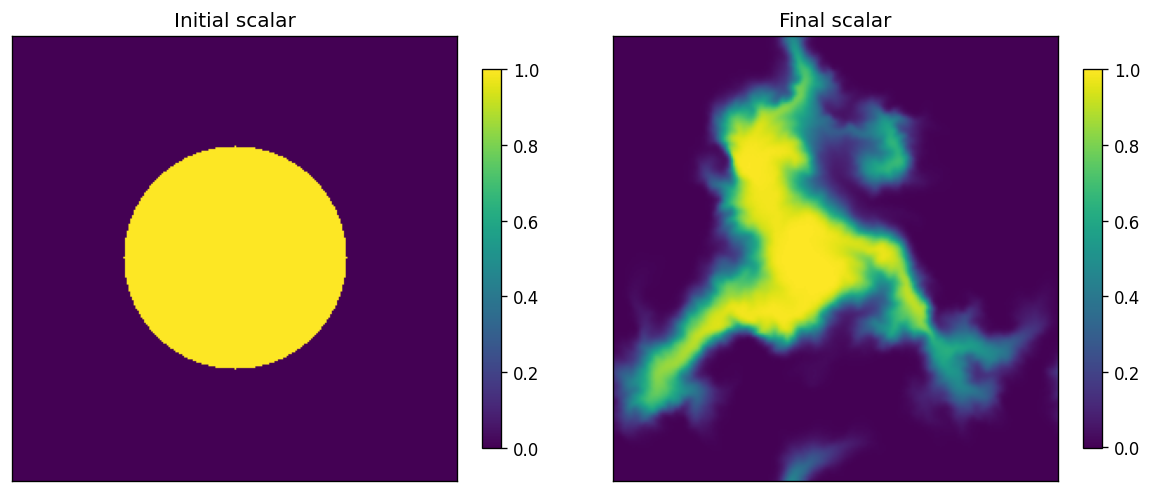

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=120, constrained_layout=True)
im0 = axs[0].imshow(theta0, origin='lower', cmap='viridis')
axs[0].set_title('Initial scalar')
plt.colorbar(im0, ax=axs[0], shrink=0.85)
im1 = axs[1].imshow(theta_final, origin='lower', cmap='viridis')
axs[1].set_title('Final scalar')
plt.colorbar(im1, ax=axs[1], shrink=0.85)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

### Snapshot timeline

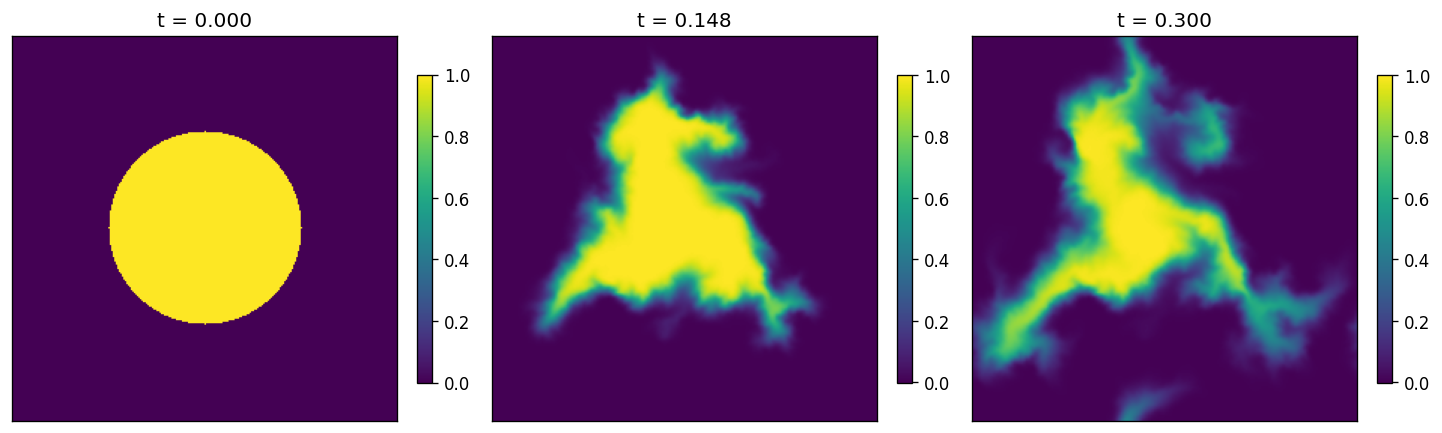

In [7]:
if diagnostics.snapshots:
    idxs = np.linspace(0, len(diagnostics.snapshots) - 1, 3, dtype=int)
    fig, axs = plt.subplots(1, len(idxs), figsize=(12, 3.5), dpi=120, constrained_layout=True)
    for ax, idx in zip(axs, idxs):
        im = ax.imshow(diagnostics.snapshots[idx], origin='lower', cmap='viridis')
        ax.set_title(f't = {diagnostics.times[idx]:.3f}')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.colorbar(im, ax=ax, shrink=0.8)
    plt.show()
else:
    print('No in-memory snapshots stored (save_every=None).')

### Scalar dissipation

In [8]:
chi = api.scalar_dissipation(theta_final, diagnostics.kappa)
print(f'Scalar dissipation rate chi = {chi:.3e}')

Scalar dissipation rate chi = 1.812e-01


### Scalar spectra

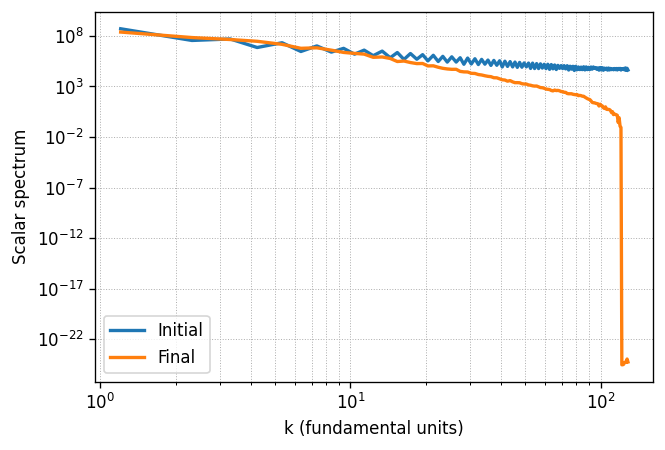

In [9]:
k_init, E_init = api.scalar_spectrum(theta0)
k_final, E_final = api.scalar_spectrum(theta_final)
plt.figure(figsize=(6, 4), dpi=120)
plt.loglog(k_init, E_init, label='Initial', lw=2)
plt.loglog(k_final, E_final, label='Final', lw=2)
plt.xlabel('k (fundamental units)')
plt.ylabel('Scalar spectrum')
plt.grid(True, which='both', ls=':', lw=0.6)
plt.legend()
plt.show()

The diagnostics object stores snapshots, frame sequences, and scalars such as time step and diffusivity. Use them to build your own analysis pipelines.